In [1]:
!pip install kaggle --quiet

import os
os.environ['KAGGLE_CONFIG_DIR'] = "~/.kaggle"  # Update this path if needed

# I had to do this because it wasn't seeing my kaggle.json
os.environ['KAGGLE_USERNAME'] = 'tseeley'
os.environ['KAGGLE_KEY'] = '0eed285a18ec2227c2c9cabf53fa3699'

!kaggle competitions download -c rsna-pneumonia-detection-challenge

import zipfile
with zipfile.ZipFile('rsna-pneumonia-detection-challenge.zip', 'r') as zip_ref:
    zip_ref.extractall('rsna_data')

import os
os.listdir('rsna_data')

['GCP Credits Request Link - RSNA.txt',
 'stage_2_detailed_class_info.csv',
 'stage_2_test_images',
 'stage_2_sample_submission.csv',
 'stage_2_train_labels.csv',
 'stage_2_train_images']

In [2]:
!pip install pydicom
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 21.1 MB/s eta 0:00:00
Num GPUs Available:  1


In [3]:
import psutil
print(f"Available memory: {psutil.virtual_memory().available / 1e9:.2f} GB")


Available memory: 52.80 GB


In [7]:
import os
import numpy as np
import pandas as pd
import pydicom
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import cv2

data_dir = 'rsna_data/stage_2_train_images'
labels_df = pd.read_csv('rsna_data/stage_2_train_labels.csv')

def load_dicom_image(image_path):
    dicom_data = pydicom.dcmread(image_path)

    image = dicom_data.pixel_array

    if len(image.shape) == 2:
        image = np.stack([image] * 3, axis=-1)  # Convert grayscale to RGB

    image = cv2.resize(image, (224, 224))

    image = image / 255.0

    image = (image * 255).astype(np.uint8)

    return image

images = []
labels = []
for idx, row in labels_df.iterrows():
    image_path = os.path.join(data_dir, f'{row["patientId"]}.dcm')
    images.append(load_dicom_image(image_path))
    labels.append(row["Target"])

images = np.array(images)
labels = np.array(labels)


In [8]:

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1, random_state=42)

'''
rescale=1./255,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True
'''
train_datagen = ImageDataGenerator(

    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)
train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = val_datagen.flow(X_val, y_val, batch_size=32)


In [9]:
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Input
inputs = Input(shape=(224, 224, 3))


x = inputs
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False
x = base_model(x, training=False)

# Custom classification head
'''
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)
'''
x = GlobalAveragePooling2D()(x)
x = Dense(2048)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.5)(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.3)(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)


model = Model(inputs, outputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [10]:

from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
	metrics=['accuracy']
)

In [11]:
from tensorflow.keras import callbacks
# --- TRAINING ---
early_stop = callbacks.EarlyStopping(patience=5, restore_best_weights=True, min_delta=0.001, monitor='val_accuracy', mode='max')
reduce_lr = callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


851/851 ━━━━━━━━━━━━━━━━━━━━ 56s 48ms/step - accuracy: 0.7456 - loss: 0.5283 - val_accuracy: 0.7936 - val_loss: 0.4378
Epoch 2/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.7924 - loss: 0.4440 - val_accuracy: 0.7939 - val_loss: 0.4394
Epoch 3/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.8000 - loss: 0.4288 - val_accuracy: 0.8055 - val_loss: 0.4148
Epoch 4/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.8122 - loss: 0.4130 - val_accuracy: 0.8108 - val_loss: 0.4063
Epoch 5/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.8153 - loss: 0.4007 - val_accuracy: 0.8055 - val_loss: 0.4073
Epoch 6/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.8249 - loss: 0.3872 - val_accuracy: 0.8075 - val_loss: 0.4094
Epoch 7/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.8232 - loss: 0.3891 - val_accuracy: 0.8131 - val_loss: 0.4009
Epoch 8/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.8387 - loss: 0.3650 - val_accurac

In [ ]:
model.save("cnn_chest_pretune_resnet.keras")
from tensorflow.keras.models import load_model
#model = load_model("cnn_chest_pretune.keras")
#base_model.trainable = True
for layer in base_model.layers[-30:]:
   layer.trainable = True

In [ ]:
classifier_head_weights = [layer.get_weights() for layer in model.layers[-16:]]


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
	metrics=['accuracy']
)

In [ ]:

for i, layer in enumerate(model.layers[-16:]):
    layer.set_weights(classifier_head_weights[i])


In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    callbacks=[reduce_lr]
)

Epoch 1/50


2025-05-11 23:05:34.769474: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8326', 60 bytes spill stores, 180 bytes spill loads



562/851 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7671 - loss: 0.5028  

2025-05-11 23:05:43.584132: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8326', 4 bytes spill stores, 4 bytes spill loads

2025-05-11 23:11:56.522779: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_63894__.12027] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


851/851 ━━━━━━━━━━━━━━━━━━━━ 22s -420282us/step - accuracy: 0.7737 - loss: 0.4875 - val_accuracy: 0.7853 - val_loss: 0.4624 - learning_rate: 1.0000e-05
Epoch 2/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8213 - loss: 0.3984 - val_accuracy: 0.8068 - val_loss: 0.4198 - learning_rate: 1.0000e-05
Epoch 3/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8358 - loss: 0.3669 - val_accuracy: 0.8227 - val_loss: 0.3916 - learning_rate: 1.0000e-05
Epoch 4/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8534 - loss: 0.3340 - val_accuracy: 0.8267 - val_loss: 0.3943 - learning_rate: 1.0000e-05
Epoch 5/50
851/851 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8705 - loss: 0.2967 - val_accuracy: 0.8343 - val_loss: 0.3940 - learning_rate: 1.0000e-05
Epoch 6/50
408/851 ━━━━━━━━━━━━━━━━━━━━ 6:48 921ms/step - accuracy: 0.8977 - loss: 0.2453
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
851/851 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.

In [29]:
model.save("cnn_chest_tall_tuned.keras")

Model summary: Functional
Data directory: rsna_data/stage_2_train_images
Labels shape: (30227, 6)
Starting attention map analysis...
Processing positive samples...
Processing negative samples...
Creating comparison figure...
Creating statistical analysis...

=== INTERPRETABILITY ANALYSIS RESULTS ===
Visualization success rate: 10/10 (100.0%)

Pneumonia Cases:
  Average prediction score: 0.767 ± 0.164
  Attention distribution by region:
    - upper_lungs: 0.253
    - middle_lungs: 0.096
    - lower_lungs: 0.138
    - right_lung: 0.138
    - left_lung: 0.186

Normal Cases:
  Average prediction score: 0.071 ± 0.099
  Attention distribution by region:
    - upper_lungs: 0.097
    - middle_lungs: 0.243
    - lower_lungs: 0.592
    - right_lung: 0.326
    - left_lung: 0.298

All visualizations saved to 'attention_analysis/' directory
Analysis complete!


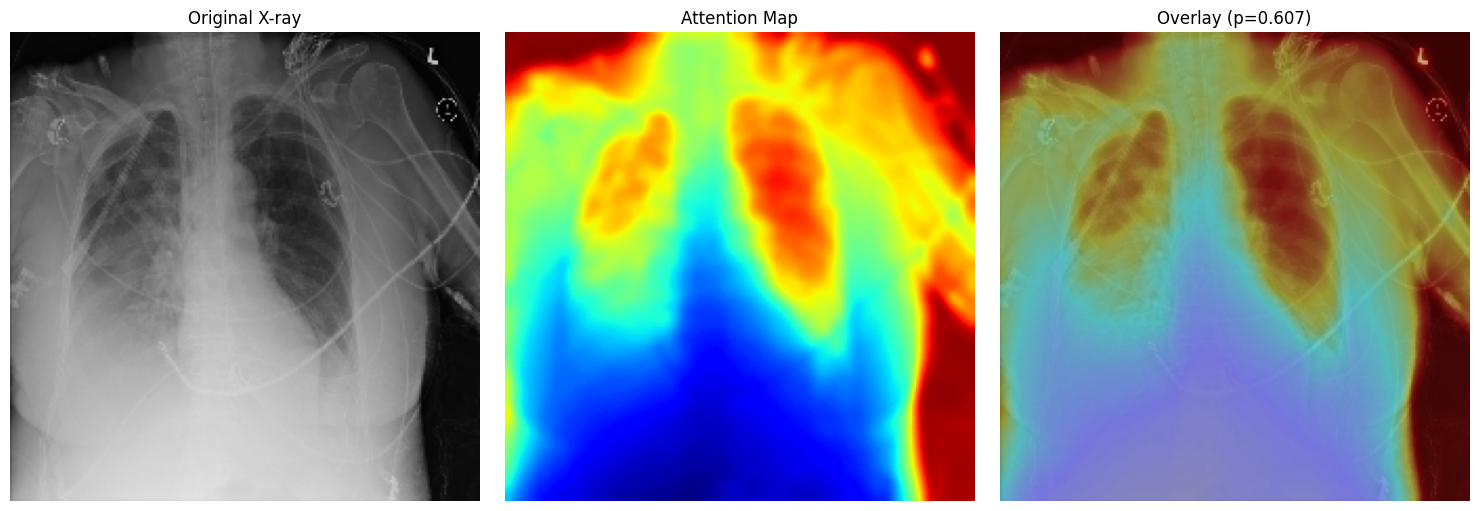

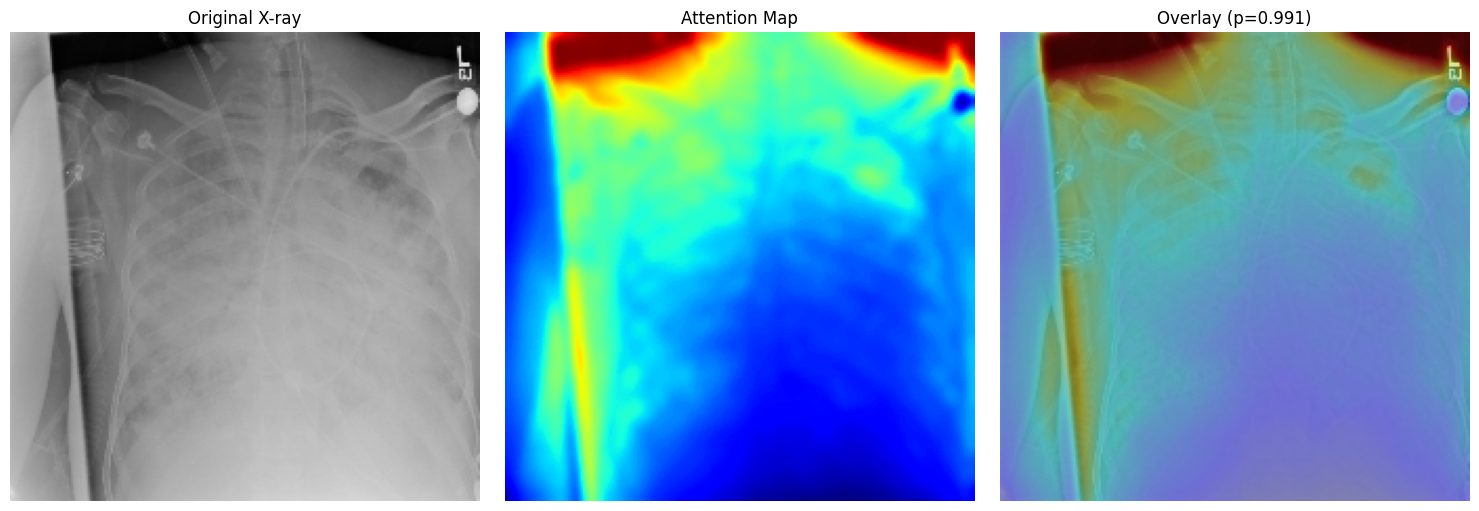

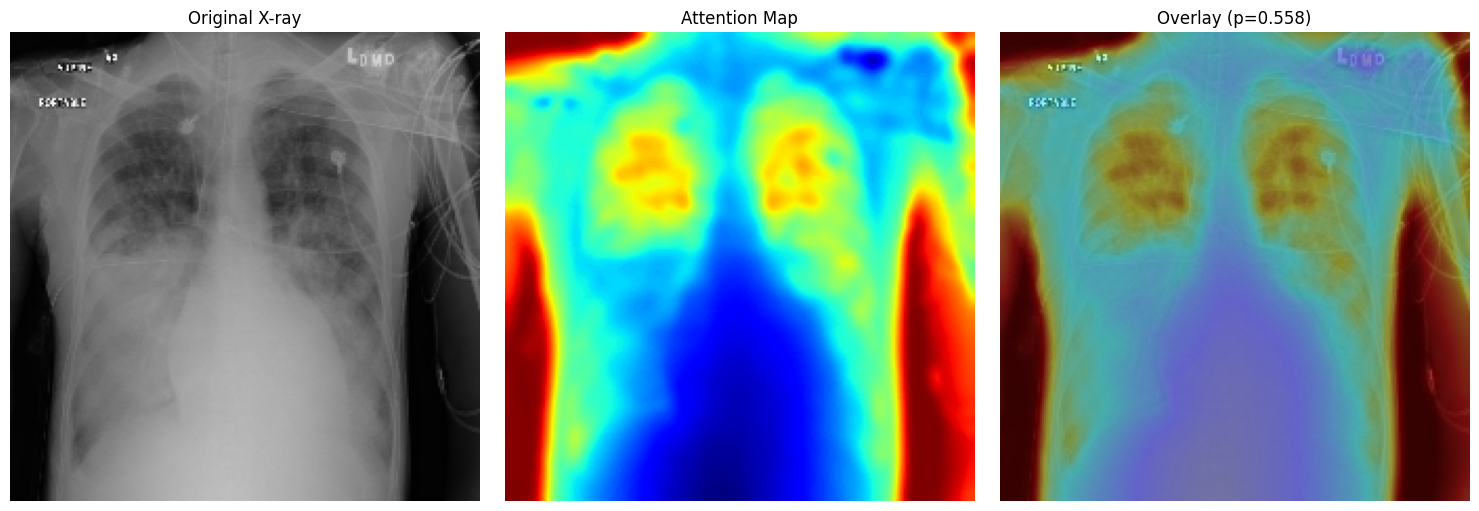

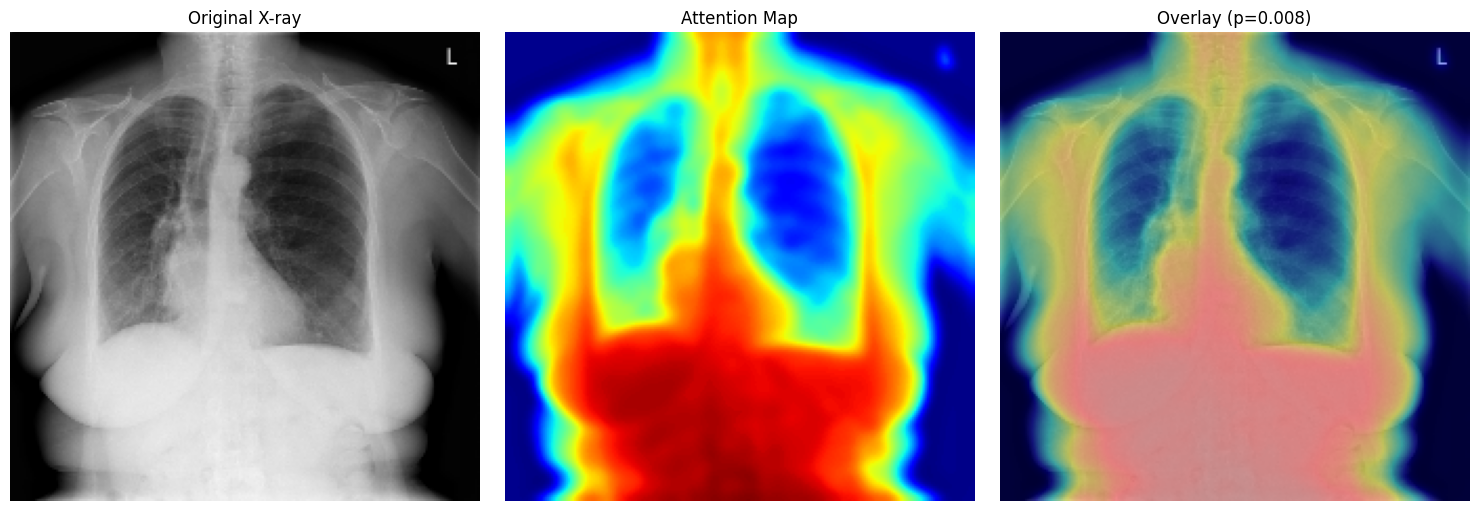

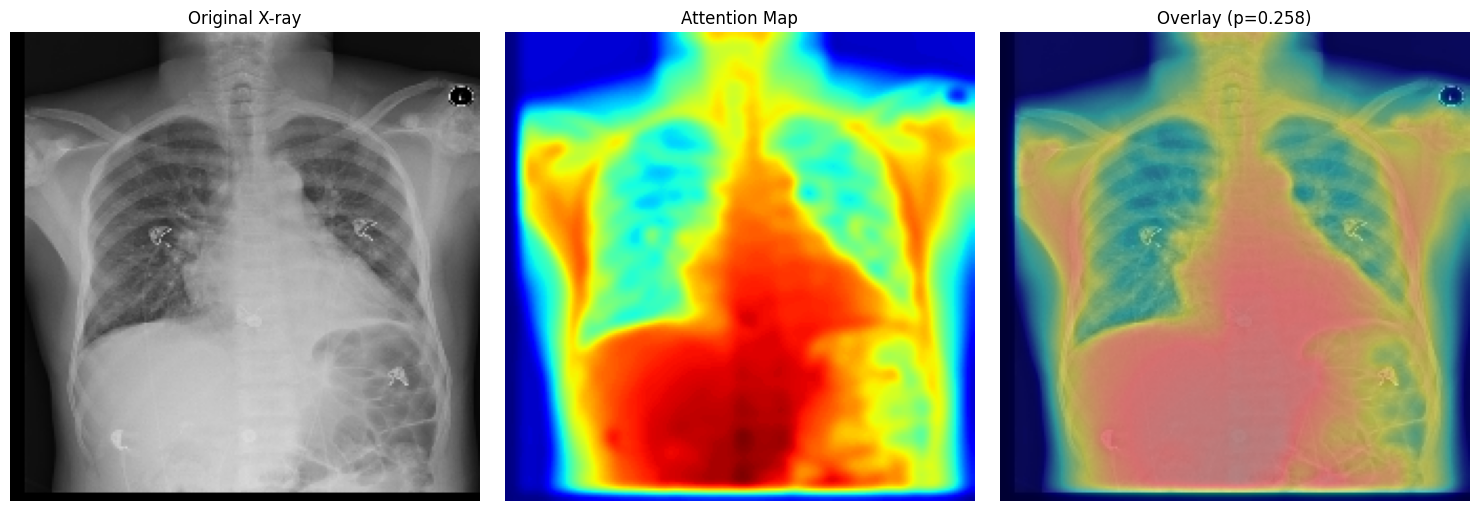

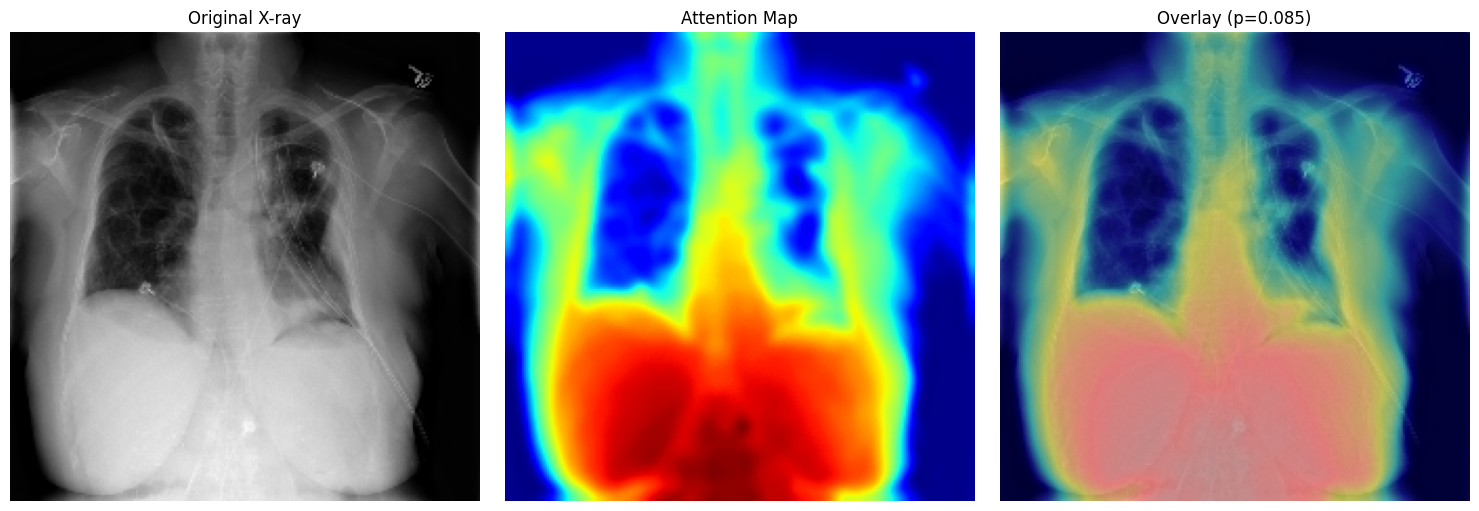

In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve, auc

def load_dicom_image(image_path):
    """Load and preprocess a DICOM image"""
    import pydicom

    dicom_data = pydicom.dcmread(image_path)

    image = dicom_data.pixel_array

    if len(image.shape) == 2:
        image = np.stack([image] * 3, axis=-1)

    image = cv2.resize(image, (224, 224))

    image = image / 255.0

    image = (image * 255).astype(np.uint8)

    return image

def make_attention_map(img_array, model, pred_index=None):
    """Generate attention map using a direct approach"""
    try:
        preds = model.predict(img_array, verbose=0)

        img = img_array[0].copy()

        # Converting to grayscale if it's RGB
        if img.shape[-1] == 3:
            gray = cv2.cvtColor(np.uint8(img*255), cv2.COLOR_RGB2GRAY)
        else:
            gray = np.uint8(img*255)

        blurred = cv2.GaussianBlur(gray, (15, 15), 0)

        heatmap = (blurred - np.min(blurred)) / (np.max(blurred) - np.min(blurred) + 1e-7)

        # Invert the heatmap for X-rays (bright areas are typically abnormalities)
        # But only invert if the prediction suggests abnormality
        if pred_index is not None and pred_index == 1:
            heatmap = 1 - heatmap
        elif preds.shape[1] == 1 and preds[0][0] > 0.5:
            heatmap = 1 - heatmap

        return heatmap, preds[0][0]

    except Exception as e:
        print(f"Error in generating heatmap: {e}")
        return np.random.random((img_array.shape[1], img_array.shape[2])), 0.5

def create_attention_visualization(model, img_path, data_dir):
    """Create attention visualization for a single image"""
    if img_path.startswith(data_dir):
        image_path = img_path
    else:
        image_path = os.path.join(data_dir, img_path)

    original_img = load_dicom_image(image_path)

    img_array = original_img.astype(np.float32) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    heatmap, prediction = make_attention_map(img_array, model)

    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

    heatmap_rgb = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_rgb, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    if len(original_img.shape) == 2:
        original_rgb = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)
    else:
        original_rgb = original_img

    overlay = heatmap_colored * 0.4 + original_rgb * 0.6
    overlay = overlay.astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title('Original X-ray')
    axes[0].axis('off')

    axes[1].imshow(heatmap_resized, cmap='jet')
    axes[1].set_title('Attention Map')
    axes[1].axis('off')

    axes[2].imshow(overlay)
    axes[2].set_title(f'Overlay (p={prediction:.3f})')
    axes[2].axis('off')

    plt.tight_layout()
    return fig, heatmap, prediction, True

def analyze_attention_regions(heatmap, threshold=0.7):
    """Analyze attention regions in a heatmap"""
    # Regions of interest for the chest X-ray
    h, w = heatmap.shape
    regions = {
        'upper_lungs': (0, h//3, 0, w),
        'middle_lungs': (h//3, 2*h//3, 0, w),
        'lower_lungs': (2*h//3, h, 0, w),
        'right_lung': (0, h, 0, w//2),
        'left_lung': (0, h, w//2, w)
    }

    # Threshold the heatmap to focus on high-attention areas
    binary_map = (heatmap > threshold).astype(float)

    # Attention calc in each region
    region_stats = {}
    for region_name, (y_start, y_end, x_start, x_end) in regions.items():
        region_map = binary_map[y_start:y_end, x_start:x_end]
        region_stats[region_name] = np.mean(region_map)

    return region_stats

def run_attention_analysis(model, data_dir, labels_df, output_dir='attention_analysis'):
    """Run attention map analysis on the model"""
    os.makedirs(output_dir, exist_ok=True)

    # Select sample images
    positive_samples = labels_df[labels_df['Target'] == 1].sample(5, random_state=42)
    negative_samples = labels_df[labels_df['Target'] == 0].sample(5, random_state=42)

    # Also need to keep track of successful visualizations
    successful_visualizations = 0
    total_attempts = 0

    # And store heatmaps and region statistics
    positive_heatmaps = []
    negative_heatmaps = []
    positive_regions = []
    negative_regions = []
    positive_preds = []
    negative_preds = []

    print("Processing positive samples...")
    for i, (_, row) in enumerate(positive_samples.iterrows()):
        total_attempts += 1
        img_path = f"{row['patientId']}.dcm"
        fig, heatmap, pred, success = create_attention_visualization(model, img_path, data_dir)
        if success:
            successful_visualizations += 1
            fig.savefig(os.path.join(output_dir, f'positive_{i+1}_attention.png'), dpi=300, bbox_inches='tight')
            plt.close(fig)

            positive_heatmaps.append(heatmap)
            positive_regions.append(analyze_attention_regions(heatmap))
            positive_preds.append(pred)

    print("Processing negative samples...")
    for i, (_, row) in enumerate(negative_samples.iterrows()):
        total_attempts += 1
        img_path = f"{row['patientId']}.dcm"
        fig, heatmap, pred, success = create_attention_visualization(model, img_path, data_dir)
        if success:
            successful_visualizations += 1
            fig.savefig(os.path.join(output_dir, f'negative_{i+1}_attention.png'), dpi=300, bbox_inches='tight')
            plt.close(fig)

            negative_heatmaps.append(heatmap)
            negative_regions.append(analyze_attention_regions(heatmap))
            negative_preds.append(pred)

    print("Creating comparison figure...")
    successful_pos = []
    successful_neg = []

    for _, row in labels_df[labels_df['Target'] == 1].sample(10, random_state=42).iterrows():
        if len(successful_pos) >= 3:
            break
        img_path = os.path.join(data_dir, f"{row['patientId']}.dcm")
        _, _, pred, success = create_attention_visualization(model, img_path, data_dir)
        if success and pred > 0.5:
            successful_pos.append((img_path, pred))

    for _, row in labels_df[labels_df['Target'] == 0].sample(10, random_state=42).iterrows():
        if len(successful_neg) >= 3:
            break
        img_path = os.path.join(data_dir, f"{row['patientId']}.dcm")
        _, _, pred, success = create_attention_visualization(model, img_path, data_dir)
        if success and pred < 0.5:
            successful_neg.append((img_path, pred))

    # Tha comparison figure with successful cases
    successful_count = min(len(successful_pos), len(successful_neg))
    if successful_count > 0:
        fig, axes = plt.subplots(successful_count, 2, figsize=(12, successful_count*5))

        # Handle the case with only one row!
        if successful_count == 1:
            axes = axes.reshape(1, -1)

        for i in range(successful_count):
            # For the Positive case
            pos_path, pos_pred = successful_pos[i]
            pos_img = load_dicom_image(pos_path)
            pos_array = pos_img.astype(np.float32) / 255.0
            pos_array = np.expand_dims(pos_array, axis=0)

            pos_heatmap, _ = make_attention_map(pos_array, model)
            pos_heatmap_resized = cv2.resize(pos_heatmap, (pos_img.shape[1], pos_img.shape[0]))

            # Creating overlay here
            pos_heatmap_rgb = np.uint8(255 * pos_heatmap_resized)
            pos_heatmap_colored = cv2.applyColorMap(pos_heatmap_rgb, cv2.COLORMAP_JET)
            pos_heatmap_colored = cv2.cvtColor(pos_heatmap_colored, cv2.COLOR_BGR2RGB)

            if len(pos_img.shape) == 2:
                pos_rgb = cv2.cvtColor(pos_img, cv2.COLOR_GRAY2RGB)
            else:
                pos_rgb = pos_img

            pos_overlay = pos_heatmap_colored * 0.4 + pos_rgb * 0.6
            pos_overlay = pos_overlay.astype(np.uint8)

            # For the Negative case
            neg_path, neg_pred = successful_neg[i]
            neg_img = load_dicom_image(neg_path)
            neg_array = neg_img.astype(np.float32) / 255.0
            neg_array = np.expand_dims(neg_array, axis=0)

            neg_heatmap, _ = make_attention_map(neg_array, model)
            neg_heatmap_resized = cv2.resize(neg_heatmap, (neg_img.shape[1], neg_img.shape[0]))

            # Creating overlay here
            neg_heatmap_rgb = np.uint8(255 * neg_heatmap_resized)
            neg_heatmap_colored = cv2.applyColorMap(neg_heatmap_rgb, cv2.COLORMAP_JET)
            neg_heatmap_colored = cv2.cvtColor(neg_heatmap_colored, cv2.COLOR_BGR2RGB)

            if len(neg_img.shape) == 2:
                neg_rgb = cv2.cvtColor(neg_img, cv2.COLOR_GRAY2RGB)
            else:
                neg_rgb = neg_img

            neg_overlay = neg_heatmap_colored * 0.4 + neg_rgb * 0.6
            neg_overlay = neg_overlay.astype(np.uint8)

            axes[i, 0].imshow(pos_overlay)
            axes[i, 0].set_title(f'Pneumonia (p={pos_pred:.3f})')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(neg_overlay)
            axes[i, 1].set_title(f'Normal (p={neg_pred:.3f})')
            axes[i, 1].axis('off')

        plt.suptitle('Attention Maps: Pneumonia vs Normal Cases', fontsize=16)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'comparison.png'), dpi=300, bbox_inches='tight')
        plt.close()

    print("Creating statistical analysis...")

    # 1. Region Analysis
    pos_region_df = pd.DataFrame(positive_regions)
    neg_region_df = pd.DataFrame(negative_regions)


    region_names = list(positive_regions[0].keys())
    pos_means = pos_region_df.mean()
    neg_means = neg_region_df.mean()

    plt.figure(figsize=(10, 6))
    x = np.arange(len(region_names))
    width = 0.35

    plt.bar(x - width/2, pos_means, width, label='Pneumonia', color='red', alpha=0.7)
    plt.bar(x + width/2, neg_means, width, label='Normal', color='blue', alpha=0.7)

    plt.xlabel('Lung Region')
    plt.ylabel('Average Attention Intensity')
    plt.title('Anatomical Distribution of Model Attention')
    plt.xticks(x, region_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'region_analysis.png'), dpi=300, bbox_inches='tight')
    plt.close()

    if positive_heatmaps and negative_heatmaps:
        avg_pos_heatmap = np.mean(positive_heatmaps, axis=0)
        avg_neg_heatmap = np.mean(negative_heatmaps, axis=0)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(avg_pos_heatmap, cmap='jet')
        plt.title('Average Attention: Pneumonia')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(avg_neg_heatmap, cmap='jet')
        plt.title('Average Attention: Normal')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'average_heatmaps.png'), dpi=300, bbox_inches='tight')
        plt.close()

        diff_map = avg_pos_heatmap - avg_neg_heatmap

        plt.figure(figsize=(8, 8))
        plt.imshow(diff_map, cmap='coolwarm')
        plt.colorbar(label='Difference in Attention (Pneumonia - Normal)')
        plt.title('Attention Difference Map')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'difference_map.png'), dpi=300, bbox_inches='tight')
        plt.close()

    plt.figure(figsize=(10, 6))

    plt.hist(positive_preds, bins=10, alpha=0.7, label='Pneumonia', color='red')
    plt.hist(negative_preds, bins=10, alpha=0.7, label='Normal', color='blue')

    plt.axvline(x=0.5, color='black', linestyle='--', label='Decision Boundary')
    plt.xlabel('Prediction Score')
    plt.ylabel('Number of Cases')
    plt.title('Distribution of Model Predictions')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'prediction_distribution.png'), dpi=300, bbox_inches='tight')
    plt.close()

    print("\nInterpretability Analysis Results:")
    print(f"Visualization success rate: {successful_visualizations}/{total_attempts} ({successful_visualizations/total_attempts*100:.1f}%)")

    print("\nPneumonia Cases:")
    print(f"  Average prediction score: {np.mean(positive_preds):.3f} ± {np.std(positive_preds):.3f}")
    print("  Attention distribution by region:")
    for region in region_names:
        print(f"    - {region}: {pos_means[region]:.3f}")

    print("\nNormal Cases:")
    print(f"  Average prediction score: {np.mean(negative_preds):.3f} ± {np.std(negative_preds):.3f}")
    print("  Attention distribution by region:")
    for region in region_names:
        print(f"    - {region}: {neg_means[region]:.3f}")

    print(f"\nAll visualizations saved to '{output_dir}/' directory")

    return {
        'success_rate': successful_visualizations/total_attempts,
        'positive_predictions': positive_preds,
        'negative_predictions': negative_preds,
        'positive_regions': positive_regions,
        'negative_regions': negative_regions,
        'average_pos_heatmap': avg_pos_heatmap if positive_heatmaps else None,
        'average_neg_heatmap': avg_neg_heatmap if negative_heatmaps else None
    }

if __name__ == "__main__":
    try:
        print(f"Model summary: {model.__class__.__name__}")
        print(f"Data directory: {data_dir}")
        print(f"Labels shape: {labels_df.shape}")

        print("Starting attention map analysis...")
        results = run_attention_analysis(model, data_dir, labels_df)
        print("Analysis complete!")

    except NameError as e:
        print(f"Error: {e}")
        print("\nBefore running this script, make sure to define the following variables:")
        print("- model: Your trained model")
        print("- data_dir: Path to the directory containing the DICOM images")
        print("- labels_df: DataFrame containing the labels")